# XGBoost
- GBM 기반, GBM 대비 빠른 수행 시간
- Early Stopping 기능 통해 수행 시간 향상
- 일반 파라미터-> 디폴트 파라미터 값을 바꾸는 경우 거의 없음
- 부스터 파라미터-> 트리 최적화, 부스팅, regulation 관련 파라미터 지칭
- 학습 테스트 파라미터-> 학습 수행 시의 객체 함수, 평가를 위한 지표를 설정하는 파라미터
- 파이썬 래퍼 XGBoost와 달리 사이킷런 XGBoost는 사이킷런과 호환이 가능

# LightGBM
- XGBoost보다 학습에 걸리는 시간이 훨씬 적음

- 카테고리형 피처의 자동 변환과 최적 분할

- 적은 데이터세트에 적용할 경우 과적합이 발생하기 쉬움

- Leaf Wise 리프 중심 트리 분할 방식을 사용

> 트리의 균형을 맞추기 않고, 최대한 손실값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하여 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨

# Stacking 앙상블
- 개별적인 여러 알고리즘을 서로 결합하여 예측 결과를 도출함
- 이때 배깅, 부스팅과 다르게 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행
- 개별적인 기반 모델과 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델로 모델 2가지가 필요함
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이 핵심

# CV세트 기반의 스태킹
- 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트 이용

In [3]:
conda install -c anaconda py-xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\MYCOM\anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          12 KB  anaconda
    ca-certificates-2022.07.19 |       haa95532_0         162 KB  anaconda
    certifi-2022.9.14          |   py39haa95532_0         159 KB  anaconda
    conda-23.1.0               |   py39haa95532_0         980 KB  anaconda
    libxgboost-1.7.3           |       hd77b12b_0         2.6 MB  anaconda
    openssl-1.1.1q             |       h2bbff1b_0         5.7 MB  anaconda
    py-xgboost-1.7.3           |   py39haa95532_0         196 KB  anaconda
    ruamel.yaml-0.17.21        |   py39h2bbff1b_0         169 KB  anaconda
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         112 KB  anaconda
    ----------------------



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [8]:
import xgboost as xgb
from xgboost import XGBClassifier

print(xgb.__version__)

1.7.3


In [11]:
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target
cancer_df=pd.DataFrame(data=X_features,columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

# 이때  target label 값의 종류는 악성 malignant이 0, 양성 benign이 1

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [12]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [13]:
# 전체 데이처 중 80% 는 학습용 데이터, 20% 는 테스트용 데이터 추출 
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [14]:
#XGBoost는 사이킷런과 달리 학습용과 테스트용 데이터 세트를 위핸 별도의 객체인 DMatrix를 생성함
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

#XGBoost의 하이퍼 파라미터 설정, 딕셔너리 형태
params={'max_depth':3,'eta':0.1,'objective':'binary:logistic','eval_metric':'logloss','early_stoppings':100}
num_rounds=400

#early_stopping_rounds 파라미터를 설정해 조기 중단을 수행하기 위해서는 eval_set와 eval_metric이 함께 설정되어야함
#eval_set: 성능 평가를 수행할 평가용 데이터 세트를 설정
#eval_metric: 평가 세트에 적용할 성능 평가 방법, 분류의 경우 error, logloss 적용
#XGBoost는 반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정

#train 데이터 세트는 'train', evaluation 데이터 세트는 'eval' 로 명기 
wlist=[(dtrain,'train'),(dtest,'eval')]
#하이퍼 파라미터와 early_stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,early_stopping_rounds=100,evals=wlist)

[15:31:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.181

[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08695
[177]	train-logloss:0.00695	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:

In [16]:
# 학습 완료 휴 이를 이용해 테스트 데이터 세트에 예측 수행
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [22]:
# 예측 성능 평가
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score, f1_score,recall_score, confusion_matrix

def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    #F1 스코어 추가
    f1=f1_score(y_test,pred)
    #Roc-Auc 추가
    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차행렬')
    print(confusion)
    #F1 score print 추가
    #Roc-Auc print 추가
    print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4},F1:{3:.4f},AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))
    
    
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[35  2]
 [ 1 76]]
정확도:0.9737,정밀도:0.9744,재현율:0.987,F1:0.9806,AUC:0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

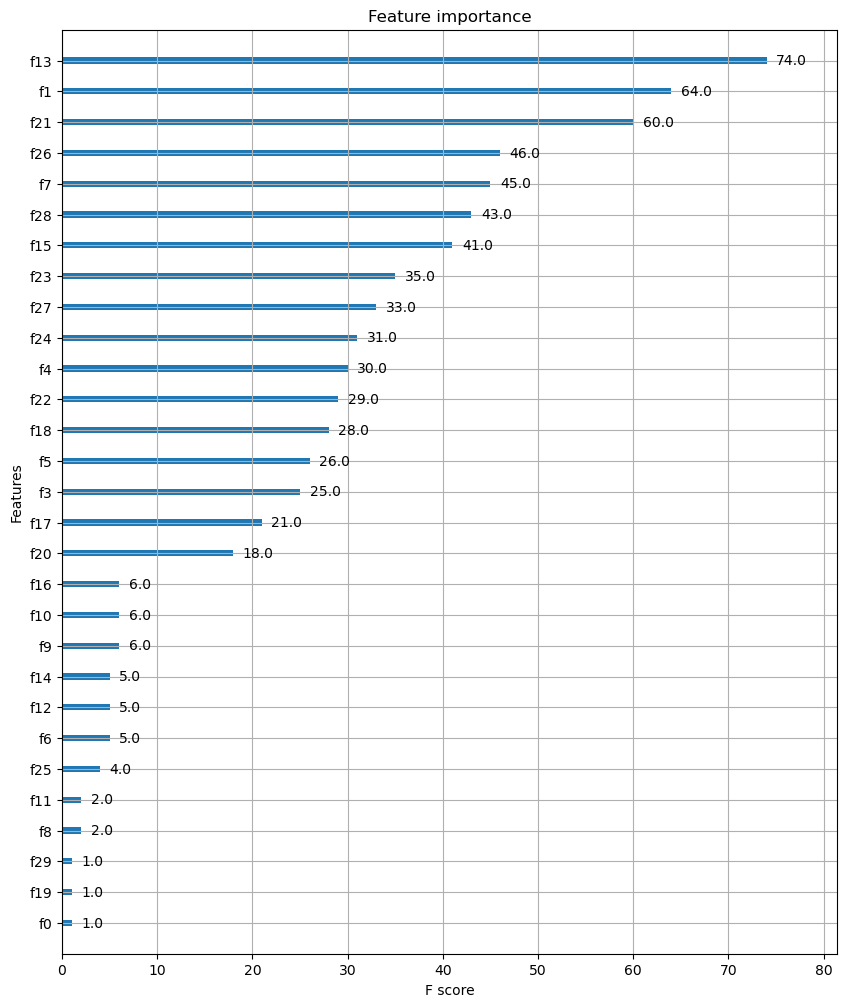

In [23]:
# xgboost 패키지에 내장된 시각화 기능 수행
# 피처의 중요도를 막대그래프로 표시, f1 스코어를 기반으로
# 이때, numpy 기반 피처데이터로 학습시에 피처명을 정확히 알 수 없으므로 f뒤에 숫자를 붙여서 
# X축에 피처를 나열 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)


In [25]:
# 사이킷런 래퍼 XGBooost 클래스인 XGBClassifier import
from xgboost import XGBClassifier
# 학습과 예측 수행
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
# 모델의 예측 성능 평가
get_clf_eval(y_test,w_preds,w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도:0.9737,정밀도:0.9744,재현율:0.987,F1:0.9806,AUC:0.9951


In [26]:
# 파이썬 래퍼 XGBoost와 동일한 평가 결과가 나옴
# 사이킷런 래퍼 XGBoost에서도 조기중단 수행 가능

from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [27]:
# 조기중단으로 학습된 XGBClassifier의 예측 성능
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도:0.9649,정밀도:0.9620,재현율:0.987,F1:0.9744,AUC:0.9954


In [28]:
# 조기중단을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 큼
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='logloss',eval_set=evals,verbose=True)
ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

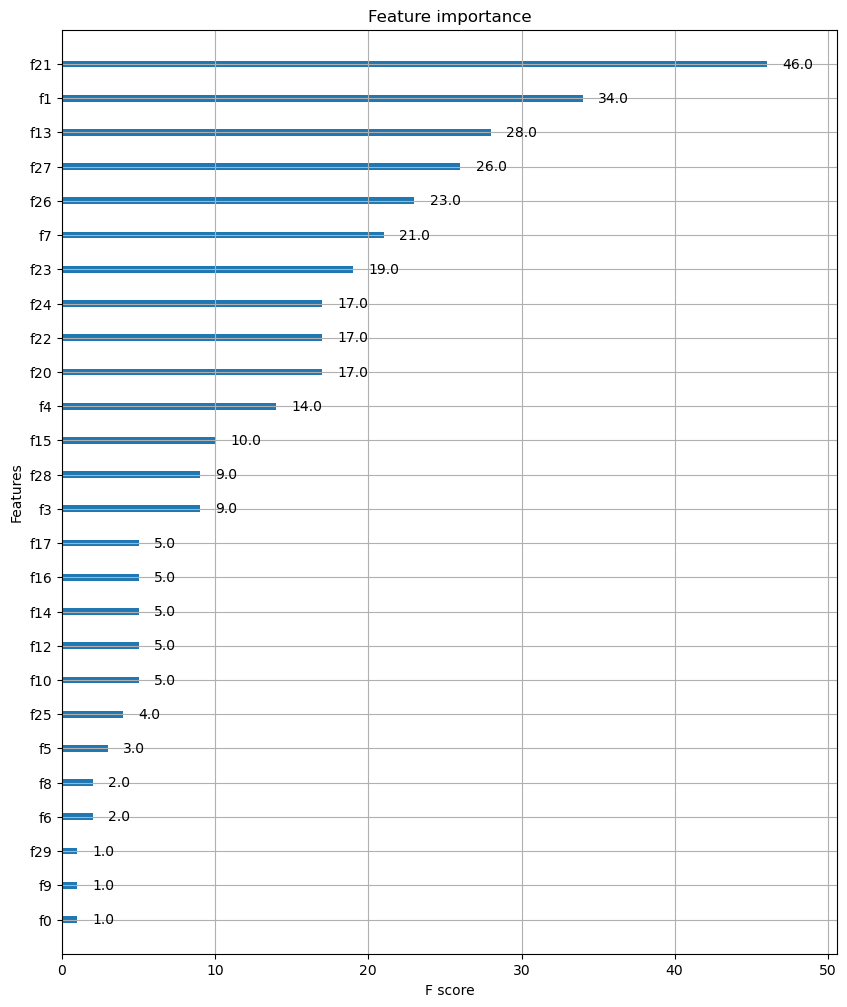

In [30]:
# 피처의 중요도를 시각화하는 모듈 plot_importance를 사이킷런 래퍼 클래스에 입력해도
# 앞에서 본 파이썬 래퍼 클래스를 입력한 결과와 똑같이 시각화 결과를 도출해낼 것

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)

### LightGBM

In [38]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\MYCOM\anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |     pyhd8ed1ab_0         296 KB  conda-forge
    conda-23.3.1               |   py39haa95532_0         972 KB
    jsonpatch-1.32             |     pyhd8ed1ab_0          14 KB  conda-forge
    jsonpointer-2.0            |             py_0           9 KB  conda-forge
    lightgbm-3.3.5             |   py39hd77b12b_0         850 KB
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  boltons            conda-forge/noarch::boltons-23.0.0-pyhd8ed1ab_0 
  jsonpatch          conda-forge/noarch::jsonpatch-1.32-pyhd8ed1ab_0 
  jsonpointer        

In [40]:
# LightGBM의 파이썬 패키지인 lightbgm 에서 LGBMClassifier import

from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(ftr,target,test_size=0.2,random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400)
#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [41]:
get_clf_eval(y_test,preds,pred_proba)

오차행렬
[[33  4]
 [ 1 76]]
정확도:0.9561,정밀도:0.9500,재현율:0.987,F1:0.9682,AUC:0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

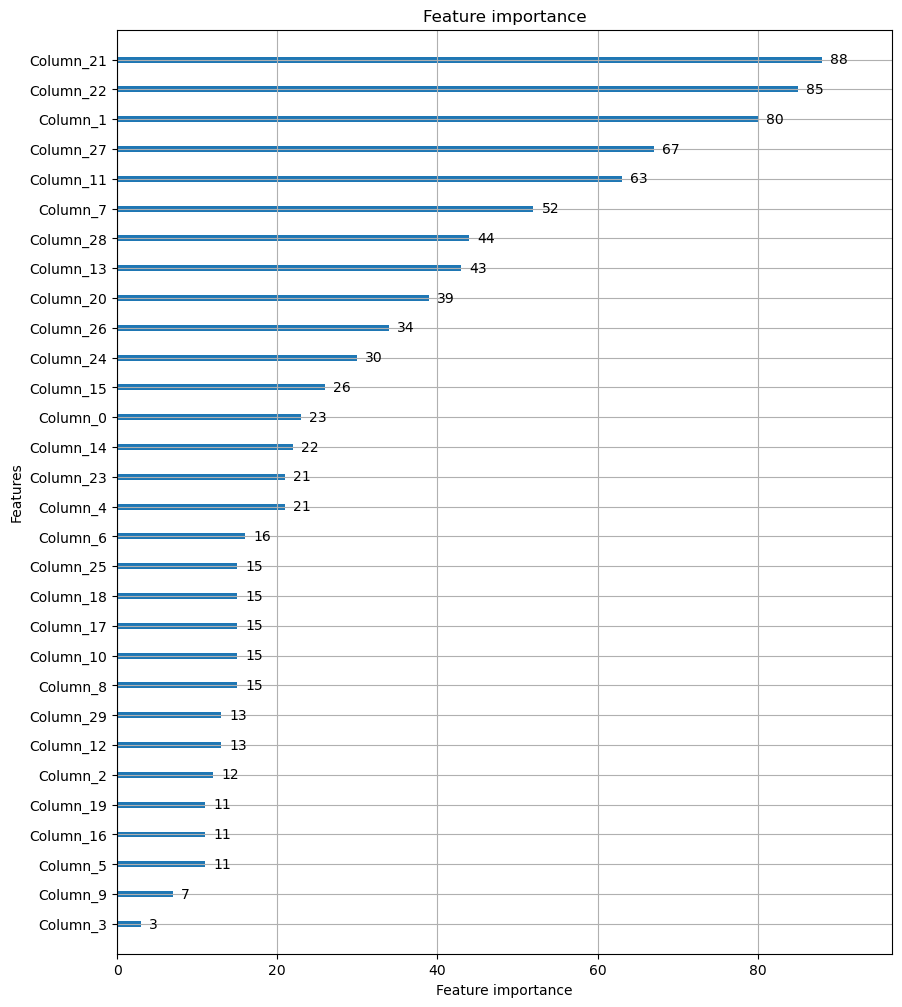

In [42]:
# XGBoost와 동일하게 피처 중요도를 시각화할 수 있는 내장 api 제공
# plot importance를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

### 기본 스태킹 모델

In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target
X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.2,random_state=0)

In [50]:
# 개별 ML 모델 생성 
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

# 개별 모델 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

# 학습된 개별 모델이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정

knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)


print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9123
에이다부스트 정확도:0.9561


In [51]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열 위치 교환, 각 칼럼 레벨로 각 알고리즘 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [52]:
#  예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정

lr_final.fit(pred,y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도:0.9737


### CV세트 기반의 스태킹

In [62]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf=KFold(n_splits=n_folds,shuffle=True,random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred=np.zeros((X_train_n.shape[0],1))
    test_pred=np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,'model 시작')
    
    for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
        # 입력한 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:',folder_counter,'시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델 학습 수행
        model.fit(X_tr,y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:,folder_counter]=model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 저장
    test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [65]:
# 여러개의 분류 모델 별로 함수 수행 
knn_train,knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

# 함수 호출로 반환된 각 모델별 학습 데이터 세트와 테스트 데이터 합치기 
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,'스태킹 테스트 피처 데이터 Shape',Stack_final_X_test.shape)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape (114, 4)


In [68]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도:0.9649
